# Amortized Inference for a NLME Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypesto import visualize, optimize, profile, engine

from inference.helper_functions import (create_mixed_effect_model_param_names,
                                        analyse_correlation_in_posterior,
                                        create_fixed_params)
from inference.inference_functions import run_population_optimization
from inference.nlme_objective import get_covariance
from inference.ploting_routines import (plot_real_vs_synthetic,
                                        plot_real_and_estimated,
                                        plot_normal_distributions,
                                        plot_parameter_estimates,
                                        visualize_pesto_result)

/Users/jonas.arruda/miniconda/envs/Amortized-NLME/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# specify which model to use
model_name = ['fröhlich-simple', 'fröhlich-detailed', 'fröhlich-sde', 
              'pharmacokinetic_model', 
              'clairon_small_model'][-1]

# Load individual model

  Activating project at `~/PyCharm Projects/Amortized-NLME/models/SimulatorSmallClairon`


using 2 layers of MultiConv1D, a  LSTM with 8 units and a dense layer with output dimension 14 as summary network
using a 8-layer cINN as inference network with 3 layers of design affine
Using normal prior
prior mean: [ 1.38629436  2.48490665  2.89037176  1.09861229 -4.60517019 -2.30258509
 -2.30258509]
prior covariance diagonal: [6 6 6 6 6 6 6]
Using the model ClaironModel


INFO:root:Performing 2 pilot runs with the ClaironModel model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 7)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 7, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from ../networks/amortizer-clairon-normal-sequence-summary-LSTM-8layers-3coupling-affine-500epochs/history_147.pkl.
INFO:root:Networks loaded from ../networks/amortizer-clairon-normal-sequence-summary-LSTM-8layers-3coupling-affine-500epochs/ckpt-147
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Model: "amortized_posterior"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  1147216   
 ibleNetwork)                                                    
                                                                 
 sequence_network (Sequence  multiple                  9086      
 Network)                                                        
                                                                 
Total params: 1156302 (4.41 MB)
Trainable params: 1156190 (4.41 MB)
Non-trainable params: 112 (448.00 Byte)
_________________________________________________________________
None


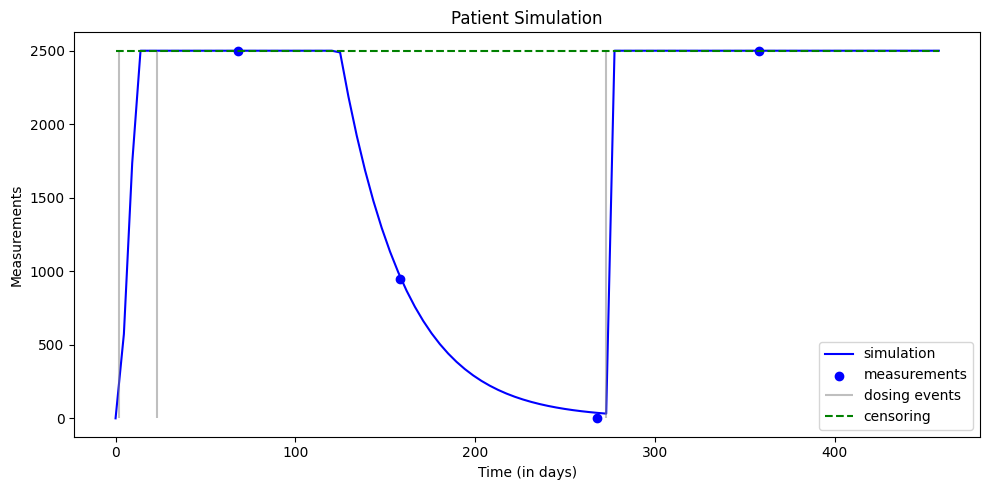

In [3]:
if model_name == 'fröhlich-simple':
    from models.froehlich_model_simple import FroehlichModelSimple
    individual_model = FroehlichModelSimple(load_best=True)
elif model_name == 'fröhlich-detailed':
    from models.froehlich_model_detailed import FroehlichModelDetailed
    individual_model = FroehlichModelDetailed(load_best=True)
elif model_name == 'fröhlich-sde':
    from models.froehlich_model_sde import FroehlichModelSDE
    individual_model = FroehlichModelSDE(load_best=True)    
elif model_name == 'pharmacokinetic_model':
    from models.pharmacokinetic_model import PharmacokineticModel
    individual_model = PharmacokineticModel(load_best=True)    
elif model_name == 'clairon_small_model':
    from models.clairon_small_model import ClaironSmallModel
    prior_type = ['normal', 'uniform'][0]
    individual_model = ClaironSmallModel(load_best=True, prior_type=prior_type)
else:
    raise NotImplementedError('model not implemented')

# assemble simulator and prior
trainer = individual_model.build_trainer('../networks/' + individual_model.network_name)
individual_model.plot_example()

## Load Data

In [4]:
# define how many data points are used for optimization
n_data = 200
load_real_data = False
# load data
true_pop_parameters = None
results_to_compare = None
if 'Froehlich' in individual_model.name:
    obs_data = individual_model.load_data(n_data=n_data, synthetic=not load_real_data, 
                                          load_egfp=True, load_d2egfp=False)  # if both are loaded, a 2d-list is returned
    if not load_real_data:
        true_pop_parameters = individual_model.load_synthetic_parameter(n_data=n_data)
    
    # load SDE data for comparison
    #from models.froehlich_model_sde import FroehlichModelSDE
    #model_sde = FroehlichModelSDE(load_best=True)
    #obs_data = model_sde.load_data(n_data=n_data, synthetic=True)
    #true_pop_parameters_sde = model_sde.load_synthetic_parameter(n_data=n_data)
else:
    if load_real_data:
        obs_data = individual_model.load_data(n_data=n_data, seed=0)
    else:
        synthetic_fixed_indices = [0, 1, 3, 4, 5, 6]
        obs_data, true_pop_parameters = individual_model.load_data(n_data=n_data, synthetic=True, 
                                                                   return_synthetic_params=True,
                                                                   synthetic_fixed_indices=None, #synthetic_fixed_indices,
                                                                   seed=0)
        
#outlier_id = [14, 71, 101, 107, 124, 171]    
#obs_data = np.array([obs_data[i] for i in range(len(obs_data)) if i not in outlier_id])

n_data = len(obs_data)  # in case less data is available
print(len(obs_data), 'individuals')

200 individuals


# Estimating Population Parameters

Now we want to use the amortizer to generate samples such that we can minimize the negative log-likelihood of the data given the population parameters of the mixed effect model:
$$
    \beta^*,\Psi^* \approx 
    \underset{\beta,\Psi}{\arg\min} -\sum_i \log\left( \frac1M \sum_j^M \frac{p(\phi_j \mid \beta,\Psi)}{p(\phi_j)} \right).
$$

Remark: the objective value is not the likelihood value since the sum over $\log p(y_i)$ is missing.


$\beta$ is called ```theta_population``` in the code.


$\log \phi$ cell specific parameters, sampled from $\mathcal{N}(\beta,\Psi)$
$$
    p( \phi \mid \beta,\Psi) = (2\pi)^{-k/2}\vert \Psi\vert^{-1/2} \prod_{l=1}^k \phi_l^{-1} \exp \left(-\frac12 (\log \phi-\beta)^T \Psi^{-1}  (\log \phi-\beta) \right)
$$

Assumptions to start with: $\Psi$ is a diagonal matrix, need better parameterization for other types

$$
    \beta^*,\Psi^* \approx
    \underset{\beta,\Psi}{\arg\min} -\sum_i \left(\log \frac1M \sum_j^M \frac{p( \phi_j \mid \beta,\Psi)}{p( \phi_j)} \right) \\
     =  \underset{\beta,\Psi}{\arg\min} -\sum_i \left(\log\left(\vert \Psi\vert^{-1/2} \right) -\log M -
    \log\left(\vert \Sigma\vert^{-1/2}\right) +\log \sum_j^M \exp \left(-\frac12 (\log\phi_j-\beta)^T \Psi^{-1}  (\log\phi_j-\beta) + \frac12 (\log\phi_j-\mu)^T \Sigma^{-1}  (\log\phi_j-\mu) \right)\right)
$$

if the prior is $p( \phi) = (2\pi)^{-k/2}\vert \Sigma\vert^{-1/2} \prod_{l=1}^k \phi_l^{-1}\exp \left(-\frac12 (\log \phi-\mu)^T \Sigma^{-1}  (\log\phi-\mu) \right)$.


For purpose of optimization we also parametrize $\Psi$ by a log-transformation since diagonal entries must be positive.

## Define Objective Function

- you have to choose the covariance format (diag or cholesky)
- if you want to use covariates, you have to specify the covariate mapping to the parameters of the log-normal distribution
- a covariate mapping takes in parameter samples (n_indv, n_samples, n_params), covariates (n_indv, n_covariates) and parameter vector with parameters needed to map the covariates into the other parameter from the mixed effects model and returns transformed parameter samples (n_indv, n_samples, n_params)

In [5]:
cov_type = ['diag', 'cholesky'][0]
use_covariates = False

In [6]:
# build covariate mapping if needed
covariates_bounds = None
covariate_mapping = None
n_covariates_params = 0
covariates = None
covariates_names = []

if use_covariates and 'fröhlich' in model_name:
    # experiment specific gamma
    covariates_names = ['$factor-\gamma_{d2eGFP}$', '$factor-var-\gamma_{d2eGFP}$']
    n_covariates_params = len(covariates_names)
    covariates_bounds = np.array([[-5, 5], [-2, 2]])
elif use_covariates and 'clairon' in model_name:
    covariates_names = ['c_age', 'c_gender']
    n_covariates_params = len(covariates_names)
    covariates_bounds = np.array([[-1, 1], [-1, 1]])

In [7]:
if use_covariates and 'fröhlich' in model_name:
    index_gamma = [i for i, x in enumerate(individual_model.param_names) if 'gamma' in x][0]
    
    # obs_data consists of two groups, first group is eGFP, second group is d2eGFP
    if covariates is None:
        assert len(obs_data) == 2, 'you should load two groups of data'
        covariates = np.concatenate((np.zeros(len(obs_data[0])), np.ones(len(obs_data[1]))))[:, np.newaxis]
        obs_data = np.concatenate((obs_data[0], obs_data[1]))
    
    
    def multi_experiment_mapping(beta: np.ndarray,
                                 psi_inverse: np.ndarray,
                                 covariates: np.ndarray,
                                 covariate_params: np.ndarray):
        # add param_of_cov*covariates to parameter gamma
        # covariate_params[0] < 0 expected since lifetime of d2eGFP is lower than eGFP
        beta_transformed = np.repeat(beta[np.newaxis, :], covariates.shape[0], axis=0)
        psi_inverse_transformed = np.repeat(psi_inverse[np.newaxis, :, :], covariates.shape[0], axis=0)
        
        shit_beta = covariate_params[0] * covariates.flatten()  # flatten since only one covariate
        shift_var = covariate_params[1] * covariates.flatten()
        
        for s_id in range(covariates.shape[0]):
            # individual_param_i = gamma_{eGFP} + gamma_{d2eGFP} * c + random_effect_{eGFP}, c in {0,1}
            beta_transformed[s_id, index_gamma] += shit_beta[s_id]
            # variance needs to be constrained
            temp_var = 1. / psi_inverse_transformed[s_id, index_gamma, index_gamma] + shift_var[s_id]
            if temp_var  <= 0.001:
                temp_var = 0.001
            psi_inverse_transformed[s_id, index_gamma, index_gamma] = 1. / temp_var
        return beta_transformed, psi_inverse_transformed
    
    covariate_mapping = multi_experiment_mapping
    
    
elif use_covariates and 'clairon' in model_name:
    _, covariates = individual_model.load_data(n_data=n_data, load_covariates=True)
    
    # todo: this is still the old kind of mapping
    def additive_covariate_mapping(param_samples: np.ndarray, 
                                   covariates: np.ndarray, 
                                   covariate_params: np.ndarray, 
                                   threshold: float = 0.001):
        # add param_of_cov*covariates to parameters
        additive_cov = np.sum(covariate_params*covariates, axis=1)
        transformed_param_samples = np.exp(param_samples)
        
        for s_id in range(transformed_param_samples.shape[0]):
            # estimating exp(pop_mean), param_cov, variance of random_effect with 0 mean
            # exp(individual_param_i) = exp(pop_mean + random_effect) + param_cov * cov_i
            transformed_param_samples[s_id, :, :] -= additive_cov[s_id]  # cov on one parameter
        # if parameters are negative, set to threshold
        transformed_param_samples[transformed_param_samples < 0] = threshold
        param_samples_cov = np.log(transformed_param_samples)
        return param_samples_cov
    
    
    def multiplicative_covariate_mapping(param_samples: np.ndarray, 
                                         covariates: np.ndarray, 
                                         covariate_params: np.ndarray):
        # add param_of_cov*covariates to parameters
        additive_cov = np.sum(covariate_params*covariates, axis=1)
        
        for s_id in range(param_samples.shape[0]):
            # estimating exp(pop_mean), param_cov, variance of random_effect with 0 mean
            # individual_param_i = pop_mean + random_effect + param_cov * cov_i
            # since parameters are log-normal distributed, results in a multiplicative effect
            param_samples[s_id, :, :] -= additive_cov[s_id] 
        return param_samples
    
    covariate_mapping = [additive_covariate_mapping, multiplicative_covariate_mapping][0]

In [8]:
mixed_effect_params_names = create_mixed_effect_model_param_names(individual_model.param_names, 
                                                                  cov_type=cov_type,
                                                                  covariates_names=covariates_names)
print(mixed_effect_params_names)

['pop-fM2', 'pop-fM3', 'pop-theta', 'pop-deltaV', 'pop-deltaS', 'pop-error_constant', 'pop-error_prop', 'var-fM2', 'var-fM3', 'var-theta', 'var-deltaV', 'var-deltaS', 'var-error_constant', 'var-error_prop']


### Analyse correlations between parameters

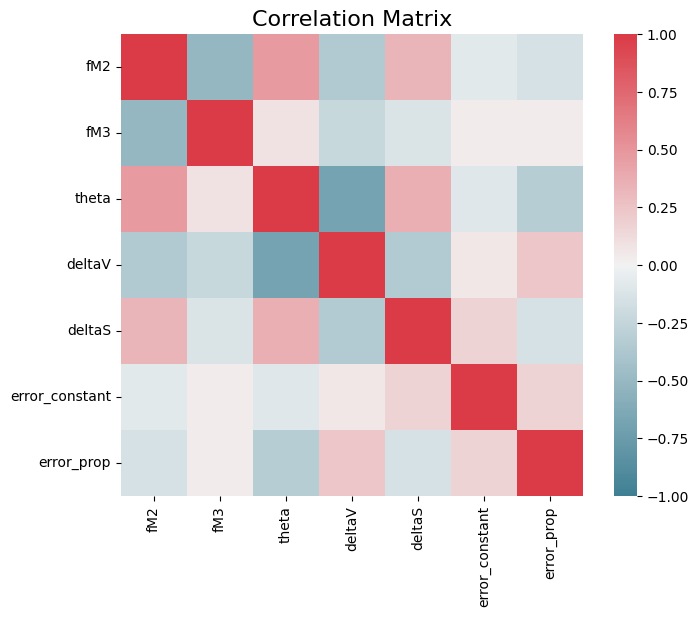

Parameter pairs of high correlation in individual posterior: []


In [9]:
high_correlation_pairs = analyse_correlation_in_posterior(model=individual_model, 
                                                          mixed_effect_params_names=mixed_effect_params_names, 
                                                          obs_data=obs_data,
                                                          threshold_corr=0.3)
print('Parameter pairs of high correlation in individual posterior:', np.array(mixed_effect_params_names)[high_correlation_pairs])

## Fixed and Random Effects

Decide which parameters to fix
- a fixed effect is modeled as a random effect with variance 0 (all parameters follow a normal distribution)
- variance of error parameters in the individual model are usually supposed to be a fixed parameter in the population model
- correlations with these error parameters are usually fixed to 0


In [10]:
if 'Froehlich' in individual_model.name:
    # fix variance of error parameters and correlations with sigma if cholesky covariance is used
    fix_names = ['var-$\sigma$'] + [name for name in mixed_effect_params_names if '\sigma' in name and 'corr_' in name]
    fixed_values = [0] * len(fix_names)
elif 'Pharmacokinetic' in individual_model.name:
    fix_error_var = ['var-$\\theta_{12}$', 'var-$\\theta_{13}$']
    fix_error_var_val = [0] * len(fix_error_var)
    # fix variance of fixed parameters
    fixed_effects_var = ['var-$\\theta_1$', 'var-$\\theta_5$', 'var-$\\theta_7$', 'var-$\\theta_8$', 
                         'var-$\\theta_{10}$', 'var-$\\theta_{12}$', 'var-$\\theta_{13}$']
    fixed_effects_var_val = [0] * len(fixed_effects_var)
    # fix mean of random effect
    random_effect_mean = ['pop-$\eta_4$']
    random_effect_mean_val = [0]
    
    # put all fixed parameters together
    fix_names = fix_error_var + fixed_effects_var + random_effect_mean
    fixed_values = fix_error_var_val + fixed_effects_var_val + random_effect_mean_val
    
    # if correlations are used, only allow the same as in the original model
    # hence correlations with the error parameter are fixed as well
    if cov_type == 'cholesky':
        non_fix_corr = ['corr_$\\theta_2-\\eta_1$_$\\theta_6-\\eta_2$', 
                        'corr_$\\theta_4-\\eta_3$_$\\theta_6-\\eta_2$', 
                        'corr_$\\theta_4-\\eta_3$_$\\eta_4$']
        fixed_corr = [x for x in mixed_effect_params_names if 'corr_' in x and x not in non_fix_corr]
        fix_names += fixed_corr
        fixed_values += [0] * len(fixed_corr)
    
elif 'Clairon' in individual_model.name:
    fix_names = ['var-error_constant', 'var-error_prop'] + [name for name in mixed_effect_params_names if 
                                                            'error' in name and 'corr_' in name]
    fixed_values = [0] * len(fix_names)
else:
    raise NotImplementedError('model not yet implemented')
    
# "fix" is here in the context of parameters which are not optimized
fixed_indices, fixed_values = create_fixed_params(fix_names=fix_names, 
                                                  fixed_values=fixed_values,
                                                  params_list=mixed_effect_params_names, 
                                                  fix_low_correlation=True,  # only applies to cholesky covariance
                                                  high_correlation_pairs=high_correlation_pairs)
print(mixed_effect_params_names)
# note: inf values in fixed_values will be set to upper or lower bound respectively

['pop-fM2', 'pop-fM3', 'pop-theta', 'pop-deltaV', 'pop-deltaS', 'pop-error_constant', 'pop-error_prop', 'var-fM2', 'var-fM3', 'var-theta', 'var-deltaV', 'var-deltaS', 'var-error_constant', 'var-error_prop']


In [11]:
# fix covariates parameters
#fixed_indices = np.append(fixed_indices, 12)
#fixed_values = np.append(fixed_values, -2)

# Run Population Optimization

In [12]:
%%time
result_optimization, obj_fun_amortized = run_population_optimization(
    individual_model=individual_model,
    data=obs_data,
    param_names=mixed_effect_params_names,
    cov_type=cov_type,
    n_multi_starts=10,
    n_samples_opt=50,
    covariates_bounds=covariates_bounds,
    covariates=covariates,
    n_covariates_params=n_covariates_params,
    covariate_mapping=covariate_mapping,
    huber_loss=True,
    x_fixed_indices=fixed_indices,
    x_fixed_vals=fixed_values,
    file_name=None, #f'../output/{model_name}-{cov_type}-n_data_{n_data}-huber-{huber_loss}.hdf5',
    verbose=True,
    trace_record=True,
    pesto_multi_processes=10,
    use_result_as_start=True,
    result=None, #result_optimization
)

result_optimization.optimize_result.summary()

Multi-start optimization:   0%|          | 0/1 [00:00<?, ?it/s]

                               free    lb_full    ub_full
pop-fM2                        True  -5.962175   8.734764
pop-fM3                        True  -4.863563   9.833376
pop-theta                      True  -4.458097  10.238841
pop-deltaV                     True  -6.249857   8.447082
pop-deltaS                     True -11.953639   2.743299
pop-error_constant             True  -9.651054   5.045884
pop-error_prop                 True  -9.651054   5.045884
$-\log$ (var-fM2)              True  -8.244349   6.452589
$-\log$ (var-fM3)              True  -8.244349   6.452589
$-\log$ (var-theta)            True  -8.244349   6.452589
$-\log$ (var-deltaV)           True  -8.244349   6.452589
$-\log$ (var-deltaS)           True  -8.244349   6.452589
$-\log$ (var-error_constant)  False  -8.244349   6.452589
$-\log$ (var-error_prop)      False  -8.244349   6.452589
                              fixed value
$-\log$ (var-error_constant)     6.907755
$-\log$ (var-error_prop)         6.907755



Multi-start optimization: 100%|██████████| 1/1 [00:23<00:00, 23.09s/it]


CPU times: user 15.9 s, sys: 2.46 s, total: 18.3 s
Wall time: 26.5 s


"## Optimization Result \n\n* number of starts: 10 \n* best value: 245.32327194572144, id=batch_0_4\n* worst value: 405.75484548078975, id=batch_0_6\n* number of non-finite values: 0\n\n* execution time summary:\n\t* Mean execution time: 16.752s\n\t* Maximum execution time: 18.826s,\tid=batch_0_3\n\t* Minimum execution time: 12.447s,\tid=batch_0_7\n* summary of optimizer messages:\n\n  |   Count | Message                                         |\n  |--------:|:------------------------------------------------|\n  |      10 | CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH |\n\n* best value found (approximately) 3 time(s)\n* number of plateaus found: 2\n\nA summary of the best run:\n\n### Optimizer Result\n\n* optimizer used: <ScipyOptimizer method=L-BFGS-B options={'maxfun': 1000, 'disp': False}>\n* message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH \n* number of evaluations: 94\n* time taken to optimize: 17.458s\n* startpoint: [ 2.50438991 -0.68621166  9.80106245  4.29498661 -2.

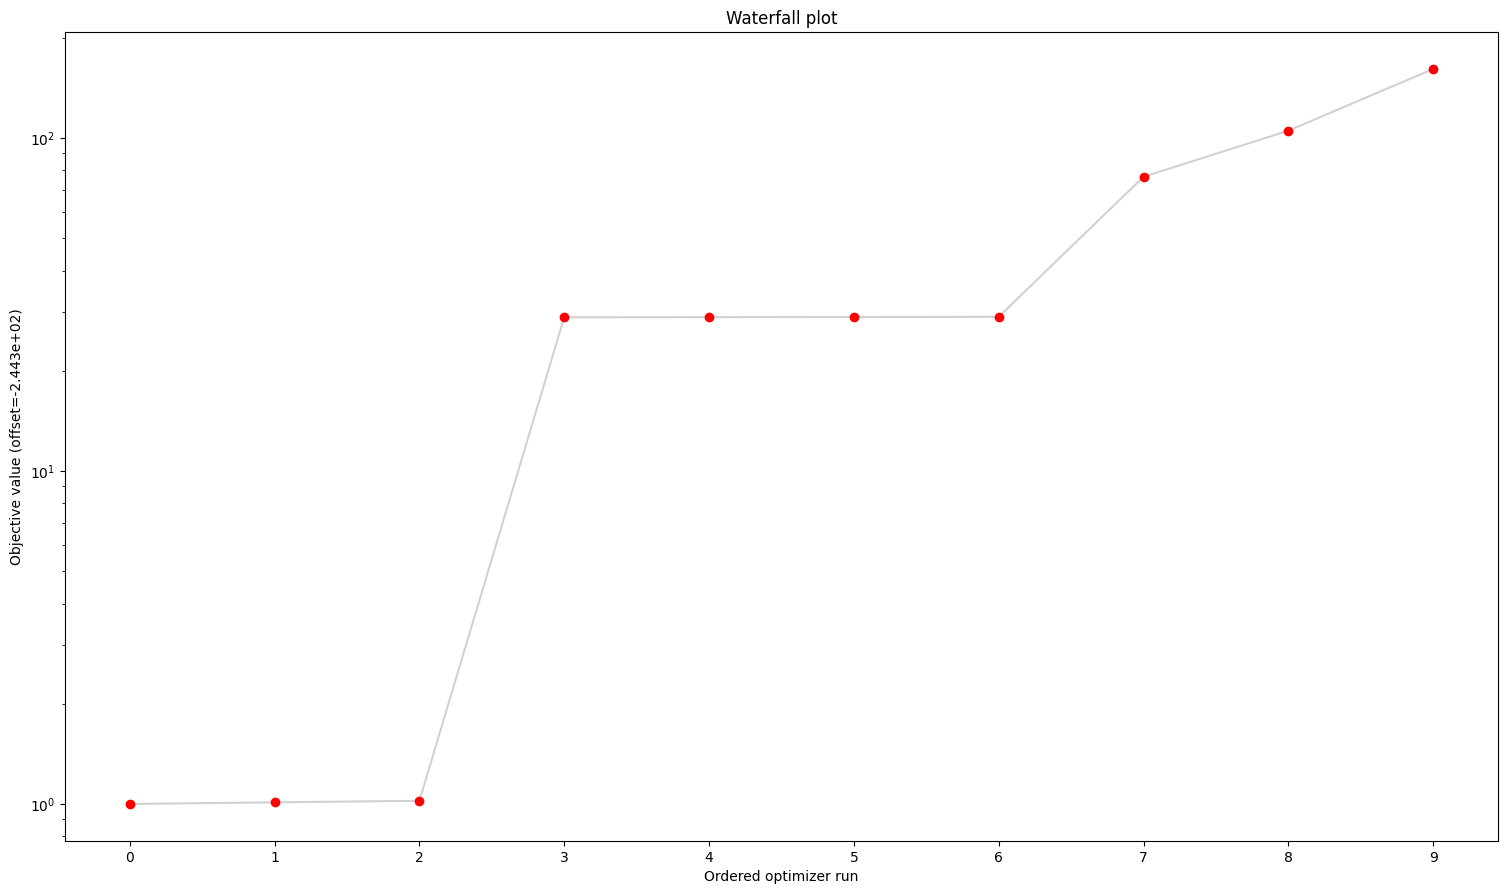

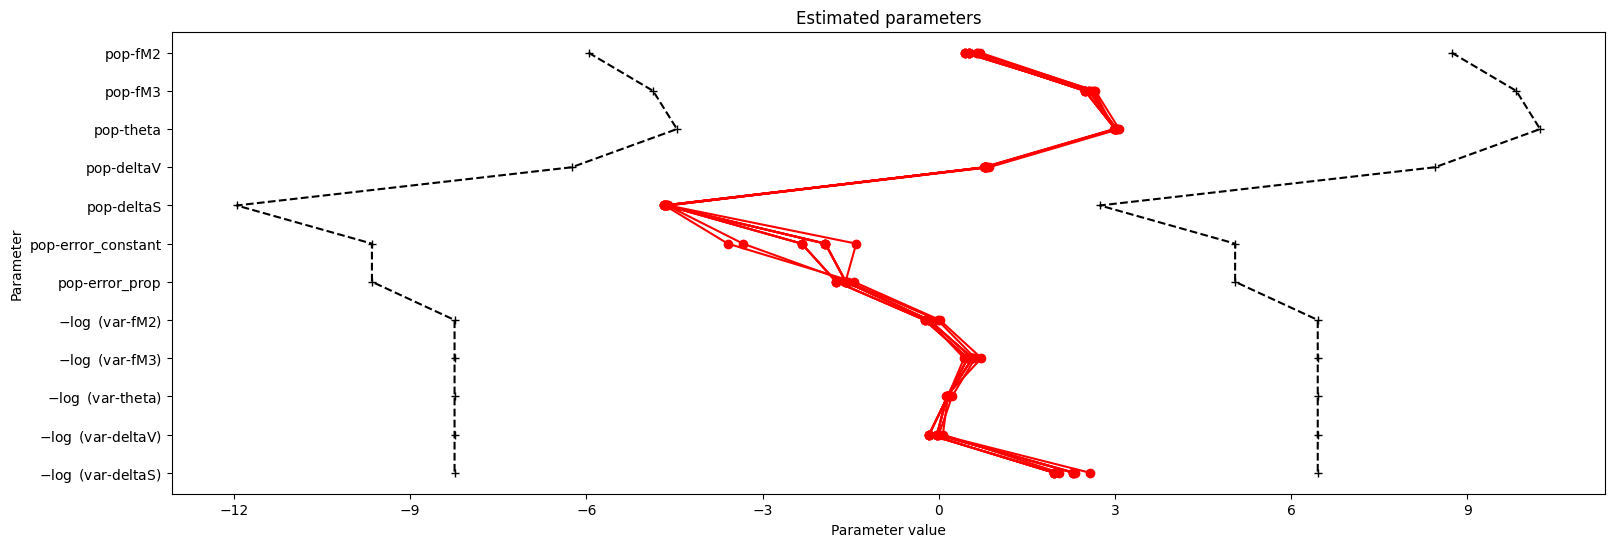

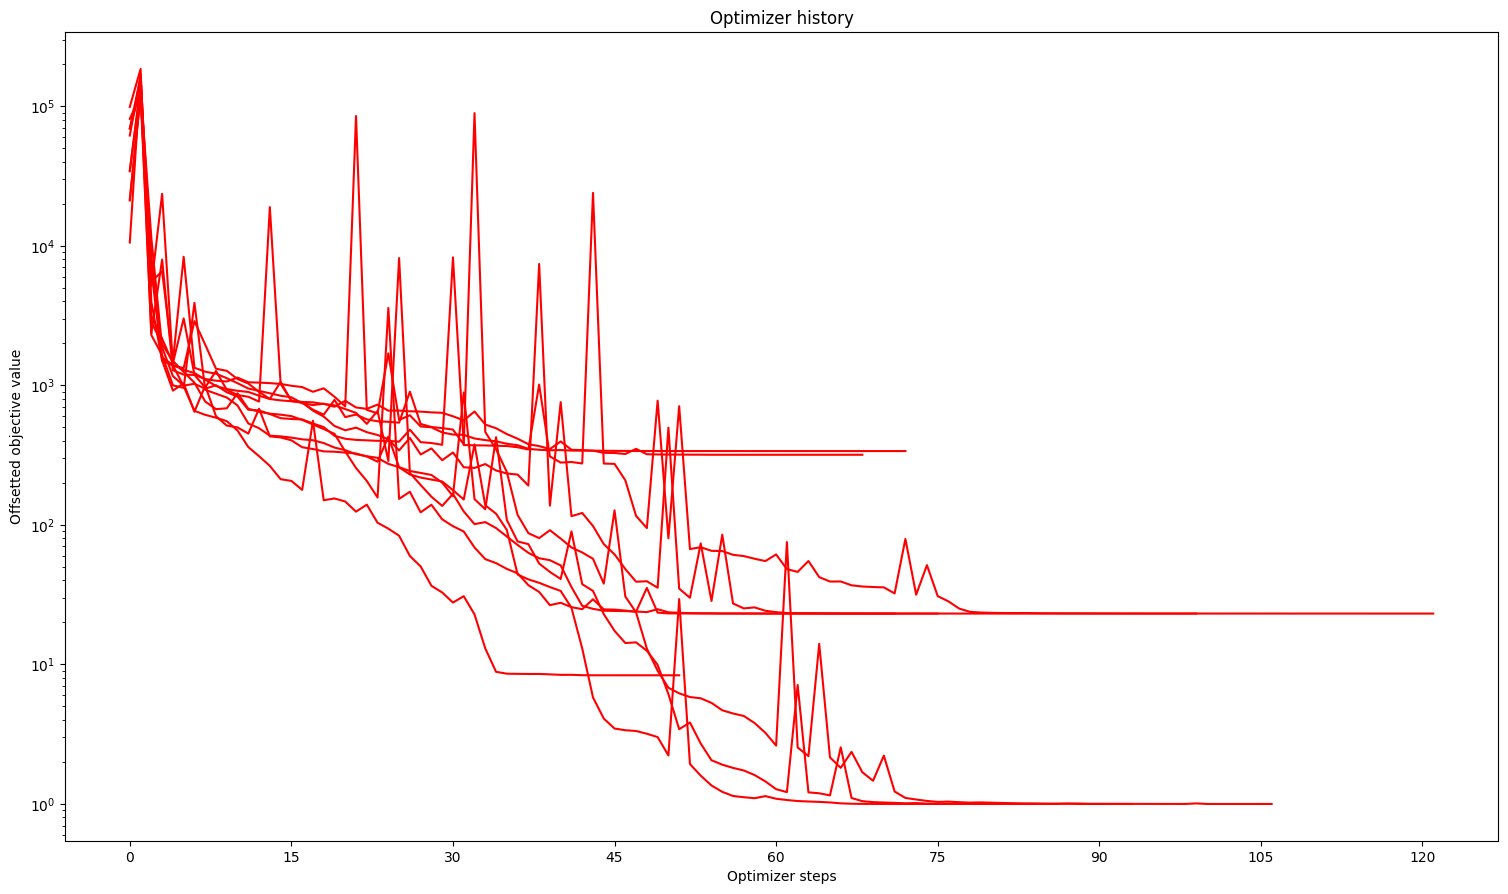

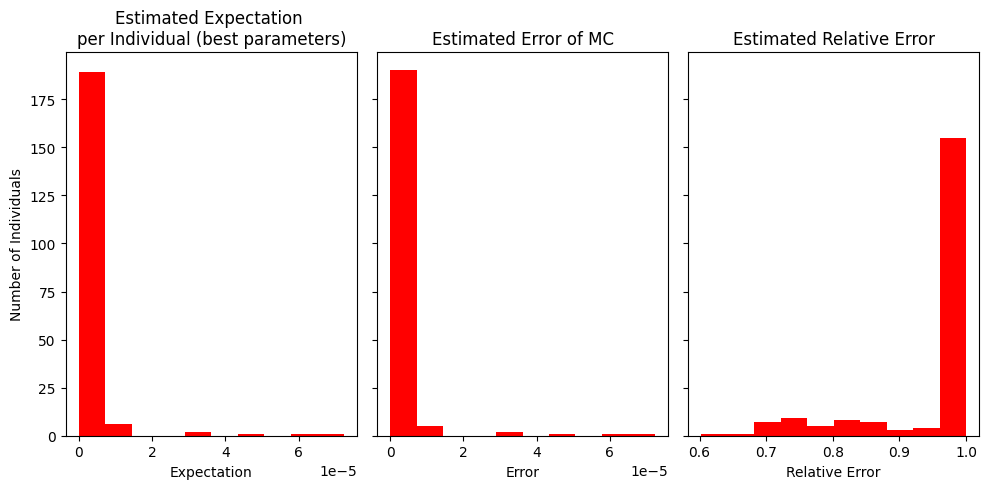

In [13]:
visualize_pesto_result(result_optimization, use_batch_coloring=True, obj_fun_amortized=obj_fun_amortized)

In [14]:
# show best result
results = result_optimization.optimize_result.x
estimated_beta = results[0][:individual_model.n_params]
estimated_var = np.exp(-results[0][individual_model.n_params:individual_model.n_params*2])
if n_covariates_params == 0:
    estimated_psi = get_covariance(results[0][individual_model.n_params:], 
                                   covariance_format=cov_type, param_dim=individual_model.n_params)
else:
    estimated_psi = get_covariance(results[0][individual_model.n_params:-n_covariates_params],
                                   covariance_format=cov_type, param_dim=individual_model.n_params)
    estimated_covariates_params = results[0][-n_covariates_params:]

display(pd.DataFrame(estimated_beta,
                     index=mixed_effect_params_names[:individual_model.n_params],
                     columns=['estimated population parameters']))
display(pd.DataFrame(estimated_var,
                     index=mixed_effect_params_names[individual_model.n_params:individual_model.n_params*2],
                     columns=['estimated population parameters']))
if cov_type == 'cholesky' or use_covariates:
    display(pd.DataFrame(results[0][individual_model.n_params*2:],
                         index=mixed_effect_params_names[individual_model.n_params*2:],
                         columns=['estimated population parameters']))
    
display(pd.DataFrame(np.var([r for r in results], axis=0),
                     index=mixed_effect_params_names,
                     columns=['variance of multi-start results']))

,estimated population parameters
pop-fM2,0.442424
pop-fM3,2.557582
pop-theta,3.026971
pop-deltaV,0.796777
pop-deltaS,-4.639768
pop-error_constant,-2.333633
pop-error_prop,-1.744764


,estimated population parameters
var-fM2,1.271673
var-fM3,0.609130
var-theta,0.865851
var-deltaV,1.031076
var-deltaS,0.101209
var-error_constant,0.001000
var-error_prop,0.001000


,variance of multi-start results
pop-fM2,0.008092
pop-fM3,0.004022
pop-theta,0.000519
pop-deltaV,0.000509
pop-deltaS,0.000583
pop-error_constant,0.408556
pop-error_prop,0.008983
var-fM2,0.007140
var-fM3,0.006079
var-theta,0.000653


In [15]:
display(estimated_beta, estimated_var)

array([ 0.44242378,  2.55758238,  3.02697099,  0.79677708, -4.63976766,
       -2.33363275, -1.74476426])

array([1.27167340e+00, 6.09129830e-01, 8.65850891e-01, 1.03107551e+00,
       1.01208822e-01, 1.00000000e-03, 1.00000000e-03])

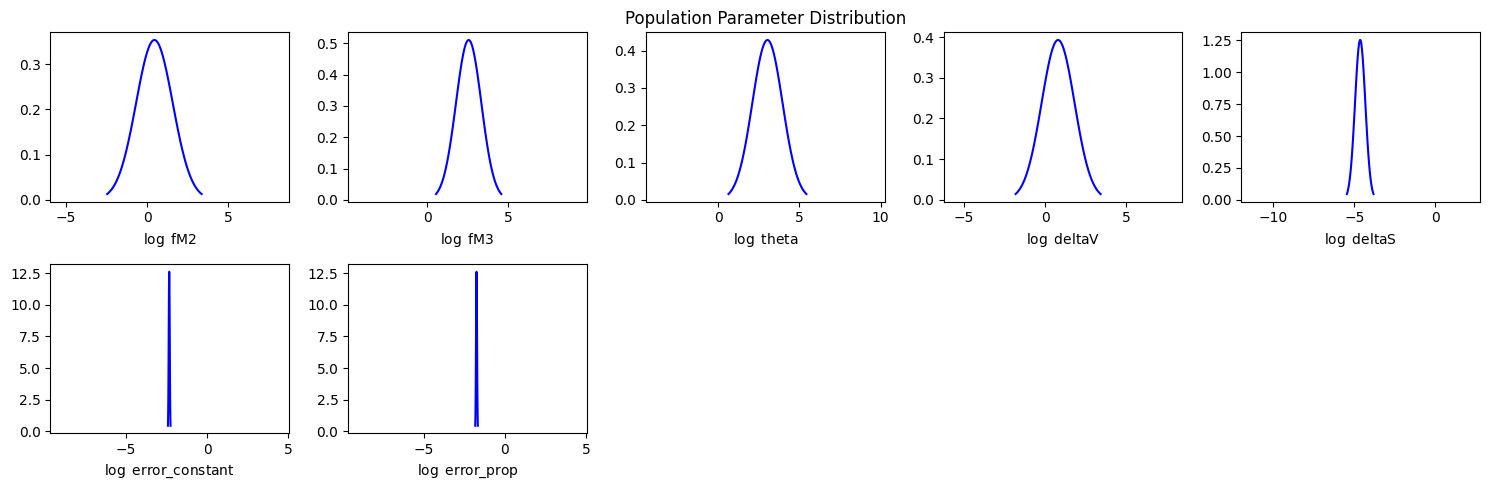

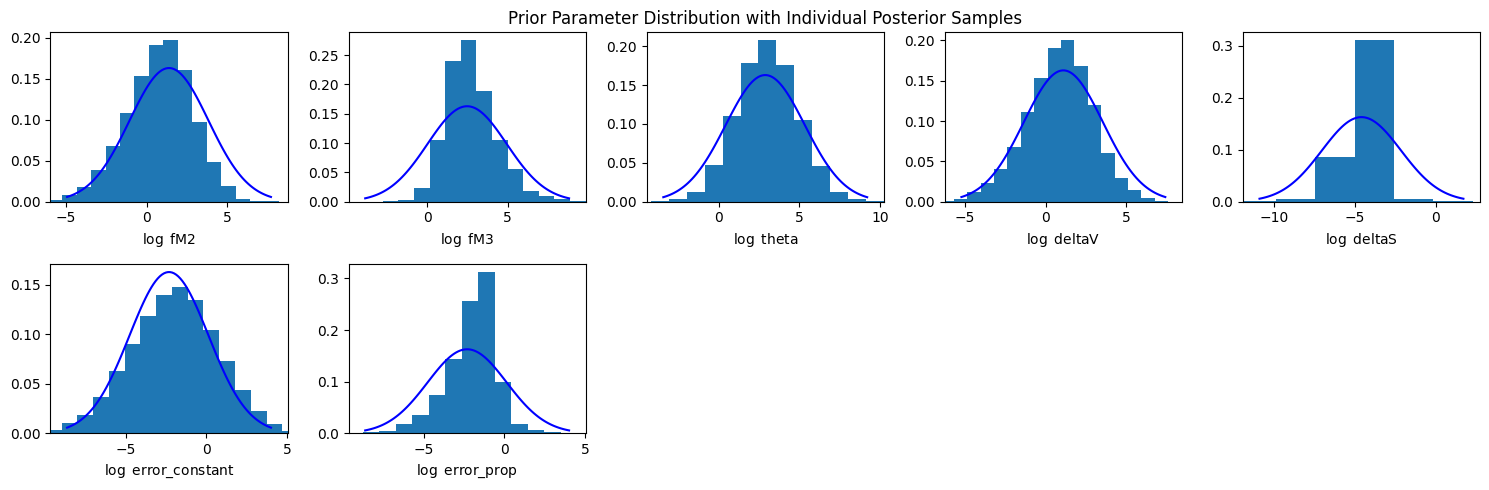

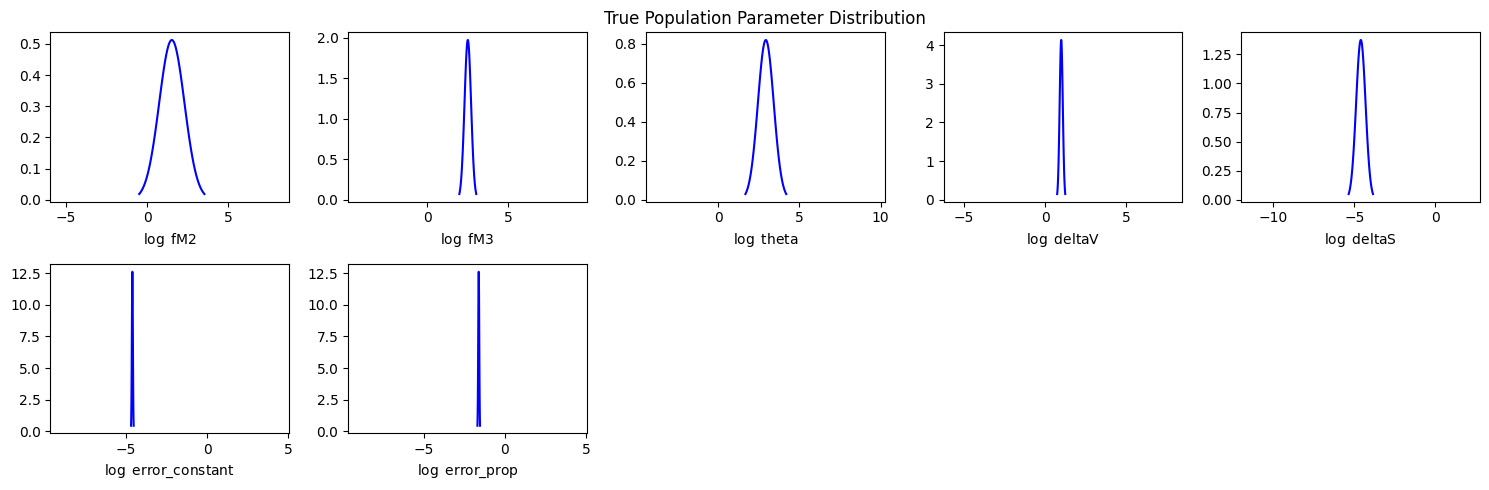

In [16]:
plot_normal_distributions(estimated_beta, estimated_psi, 
                          title='Population Parameter Distribution',
                          lb=result_optimization.problem.lb_full,
                          ub=result_optimization.problem.ub_full,
                          param_names_plot=individual_model.log_param_names)

plot_normal_distributions(individual_model.prior_mean, individual_model.prior_cov, 
                          title='Prior Parameter Distribution with Individual Posterior Samples',
                          posterior_samples=obj_fun_amortized.param_samples,
                          lb=result_optimization.problem.lb_full,
                          ub=result_optimization.problem.ub_full,
                          param_names_plot=individual_model.log_param_names)

if true_pop_parameters is not None:
    if true_pop_parameters.ndim == 2:
        true_mean = np.mean(true_pop_parameters, axis=0)
        true_cov = np.diag(np.var(true_pop_parameters, axis=0))
    else:
        true_mean = true_pop_parameters[:individual_model.n_params]
        true_cov = np.diag(true_pop_parameters[individual_model.n_params:])
    true_cov[true_cov < 0.001] = 0.001  # smaller cannot be estimated
    
    plot_normal_distributions(true_mean, 
                              true_cov, 
                              title='True Population Parameter Distribution',
                              #posterior_samples=obj_fun_amortized.param_samples,
                              lb=result_optimization.problem.lb_full,
                              ub=result_optimization.problem.ub_full,
                              param_names_plot=individual_model.log_param_names)

In [17]:
if 'fröhlich' in model_name:
    plot_real_vs_synthetic(estimated_mean=estimated_beta,
                           estimated_cov=estimated_psi,
                           data=obs_data[:n_data//2] if n_covariates_params > 0 else obs_data,
                           model_name=individual_model.name,
                           n_trajectories=n_data//2 if n_covariates_params > 0 else n_data,
                           simulator=individual_model.simulator,
                           #save_fig='dif_ode', #model_name+'_eGFP_dif' if load_real_data else model_name+'_synthetic_dif',
                           #estimation_function=np.median,
                           ylim=(-1.,1.),
                           seed=0)
    plot_real_and_estimated(estimated_mean=estimated_beta,
                           estimated_cov=estimated_psi,
                           data=obs_data[:n_data//2] if n_covariates_params > 0 else obs_data,
                           model_name=individual_model.name,
                           n_trajectories=n_data//2 if n_covariates_params > 0 else n_data,
                           simulator=individual_model.simulator,
                           #save_fig=model_name+'_eGFP_estimate' if load_real_data else model_name+'_synthetic_estimate',
                           seed=0)
    
    if n_covariates_params > 0:
        estimated_beta_d2, estimated_inv_psi_d2 = covariate_mapping(estimated_beta, 
                                                                    np.linalg.inv(estimated_psi), 
                                                                    covariates, 
                                                                    estimated_covariates_params)
        estimated_beta_d2 = estimated_beta_d2[-1]  # only second group, mean is the same for the whole group
        estimated_inv_psi_d2 = estimated_inv_psi_d2[-1]
        estimated_psi_d2 = np.linalg.inv(estimated_inv_psi_d2)
        
        plot_real_vs_synthetic(estimated_mean=estimated_beta_d2,
                           estimated_cov=estimated_psi_d2,
                           data=obs_data[n_data//2:],
                           model_name=individual_model.name,
                           n_trajectories=n_data//2,
                           simulator=individual_model.simulator,
                           ylim=(-1.,1.),
                           seed=0)
        plot_real_and_estimated(estimated_mean=estimated_beta_d2,
                               estimated_cov=estimated_psi_d2,
                               data=obs_data[n_data//2:],
                               model_name=individual_model.name,
                               n_trajectories=n_data//2,
                               simulator=individual_model.simulator,
                               seed=0)

In [18]:
true_mean = np.mean(true_pop_parameters, axis=0)
true_cov = np.diag(np.var(true_pop_parameters, axis=0))

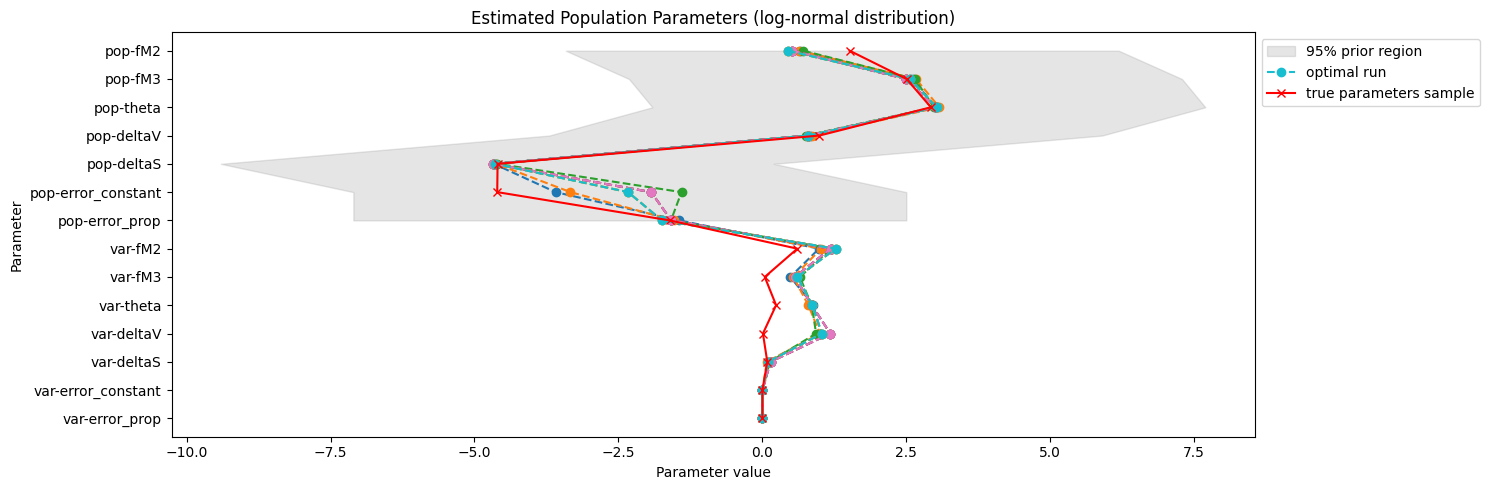

In [19]:
results_transformed = [np.concatenate((r[:individual_model.n_params], 
                                       np.exp(-r[individual_model.n_params:individual_model.n_params*2]))) 
                       for r in results]

plot_parameter_estimates(result_list=results_transformed,
                         param_names_plot=mixed_effect_params_names,
                         prior_mean=individual_model.prior_mean,
                         prior_std=individual_model.prior_std,
                         #run_names=['monolix_1', 'monolix_2', 'monolix_3', 'monolix_last'],
                         true_parameters=np.concatenate((true_mean, true_cov.diagonal())),
                         )

# Uncertainty Analysis

Uncertainty based on profiles -> more accurate

In [ ]:
profile_options = profile.ProfileOptions(
    min_step_size=0.001, #0.001
    step_size_factor=1.25, #1.25
    delta_ratio_max=0.1, #0.1
    default_step_size=0.01, #0.01
    ratio_min=0.145 #0.145
)

result_optimization = profile.parameter_profile(
    problem=result_optimization.problem,
    result=result_optimization,
    optimizer=optimize.ScipyOptimizer(),
    engine=engine.MultiProcessEngine(10),
    #profile_options=profile_options,
    #filename=f'output/uncertainty/{model.name}_cells_{n_data}_samples_{50}.hd5',
    #overwrite=True
)

In [ ]:
visualize.profiles(result_optimization, size=(16,12))
plt.show()

In [ ]:
ax = visualize.profile_cis(result_optimization)
ax.set_title('Approximate Confidence Intervals \n Based on Profiles')
plt.tight_layout()
plt.show()

Uncertainty based on FIM

In [ ]:
result_optimization = profile.approximate_parameter_profile(
    problem=result_optimization.problem,
    result=result_optimization,
)

In [ ]:
visualize.profiles(result_optimization)
plt.show()